# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run scvi-sterescope](#scvi-sterescope)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
# read cell2location model results
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/visium_human_ln/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'

run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

sp_data_file = c2l_results_folder + 'std_model/'+run_name+'/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_vis.raw.var['SYMBOL'] = adata_vis.raw.var.index
adata_vis.raw.var.index = adata_vis.raw.var['gene_ids']
adata_vis.raw.var.index.name = None


adata_vis.var['SYMBOL'] = adata_vis.var.index
adata_vis.var.index = adata_vis.var['gene_ids']
adata_vis.var.index.name = None

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [4]:
reg_mod_name = 'RegressionNBV4Torch_57covariates_73260cells_10237genes'
reg_path = f'{c2l_results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

In [5]:
adata_snrna_raw.raw.var['SYMBOL'] = adata_snrna_raw.raw.var.index
adata_snrna_raw.raw.var.index = adata_snrna_raw.raw.var['GeneID-2']
adata_snrna_raw.raw.var.index.name = None

In [6]:
adata_snrna_raw.raw.var_names, adata_snrna_raw.raw.var['SYMBOL']

(Index(['ENSG00000188976', 'ENSG00000188290', 'ENSG00000187608',
        'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808',
        'ENSG00000160087', 'ENSG00000169972', 'ENSG00000224051',
        'ENSG00000162576',
        ...
        'ENSG00000276345', 'ENSG00000277856', 'ENSG00000275063', 'IGH_VDJsum',
        'IGK_VDJsum', 'IGL_VDJsum', 'TCRA_VDJsum', 'TCRB_VDJsum', 'TCRD_VDJsum',
        'TCRG_VDJsum'],
       dtype='object', length=10237),
 ENSG00000188976          NOC2L
 ENSG00000188290           HES4
 ENSG00000187608          ISG15
 ENSG00000186891       TNFRSF18
 ENSG00000186827        TNFRSF4
                       ...     
 IGL_VDJsum          IGL_VDJsum
 TCRA_VDJsum        TCRA_VDJsum
 TCRB_VDJsum        TCRB_VDJsum
 TCRD_VDJsum        TCRD_VDJsum
 TCRG_VDJsum        TCRG_VDJsum
 Name: SYMBOL, Length: 10237, dtype: object)

In [7]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_Subset_{i}' for i in adata_snrna_raw.obs['Subset'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_Subset_{i}', '', i) for i in adata_snrna_raw.obs['Subset'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

inf_aver = inf_aver.loc[adata_snrna_raw.raw.var['SYMBOL'], :]
inf_aver.index = adata_snrna_raw.raw.var_names

In [8]:
inf_aver

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,B_mem,B_naive,B_plasma,B_preGC,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
ENSG00000188976,0.389986,0.214435,0.256271,2.956784e-01,1.257083e-01,0.147153,0.151172,0.122755,0.230796,3.209226e-01,...,0.111511,0.126056,0.166565,0.103764,0.094503,0.202703,0.310293,0.164446,0.131172,1.553225e-01
ENSG00000188290,0.001658,0.000012,0.000026,1.760481e-02,2.063625e-02,0.009338,0.027511,0.005316,0.000022,1.540930e-02,...,0.040316,0.031491,0.060974,0.014621,0.004839,0.018781,0.145339,0.304292,0.057148,1.146690e+00
ENSG00000187608,0.305257,0.138387,0.194006,3.523145e-01,4.158280e+00,0.075383,0.180887,0.068329,0.278930,6.063494e-02,...,0.176523,0.345447,0.309671,0.223379,0.255122,0.380937,1.813222,0.579268,0.279670,2.518890e-01
ENSG00000186891,0.016858,0.000055,0.048861,2.888634e-02,2.197197e-03,0.003020,0.002943,0.000163,0.117772,1.235234e-01,...,0.012353,0.309472,0.001328,0.049863,0.009768,0.000078,0.313490,0.922481,0.387692,1.563772e-09
ENSG00000186827,0.005551,0.000005,0.002945,7.722527e-03,5.199437e-03,0.000588,0.002372,0.000113,0.066400,3.887395e-02,...,0.125807,0.636628,0.028578,0.043257,0.011839,0.000788,0.511069,1.753242,0.793970,1.614110e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,9.948876,7.563540,3.652213,9.407078e+00,4.041258e+00,2.961928,3.139248,2.823470,109.727700,3.701239e+00,...,0.008561,0.015481,0.017801,0.025344,0.033933,0.004070,0.039067,0.027824,0.010213,1.616372e-02
TCRA_VDJsum,0.031178,0.001534,0.011304,5.098840e-02,4.094036e-10,0.000387,0.000389,0.000087,0.062889,7.492414e-04,...,2.594676,2.544148,2.547520,2.249395,2.027942,2.204234,4.086637,2.899816,3.444732,2.479343e-01
TCRB_VDJsum,0.051580,0.000504,0.002989,3.281814e-04,2.296285e-03,0.000485,0.002994,0.000680,0.106378,3.955359e-04,...,3.988787,6.722402,3.845822,2.744595,3.262480,3.290963,7.399317,7.432308,4.821861,1.205301e-01
TCRD_VDJsum,0.000339,0.001759,0.002099,9.781692e-10,5.895333e-10,0.000099,0.000496,0.000015,0.000500,3.789579e-10,...,0.041513,0.019695,0.034700,0.198152,0.095711,0.058952,0.015891,0.017350,0.028833,1.754361e-09


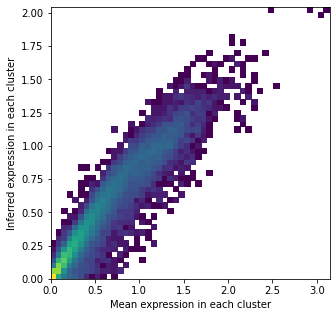

In [9]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'Subset')
aver = aver.loc[adata_snrna_raw.raw.var_names, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

### Run NNLS-autogenes <a class="anchor" id="NNLS-autogenes"></a>

In [10]:
# choose genes shared between datasets
ind = adata_vis.var_names[adata_vis.var_names.isin(inf_aver.index)]
inf_aver = inf_aver.loc[ind, :]

gen	nevals	pareto	correlation    	distance           
0  	100   	1     	412.31 - 412.31	54456.62 - 54456.62
1  	100   	1     	412.31 - 412.31	54456.62 - 54456.62


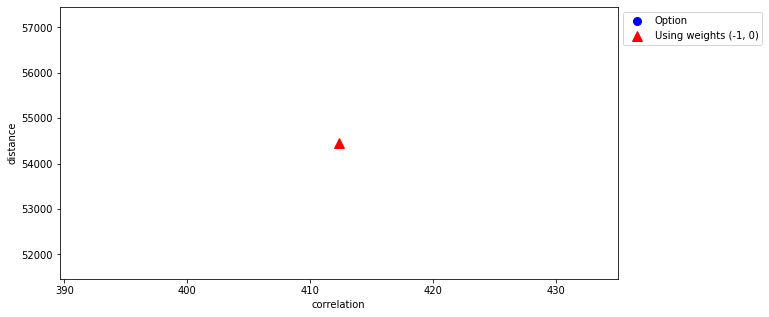

0.5169548432032267 min
0.022550777594248454 min


In [12]:
import autogenes as ag

# Select all genes - just use the regression models
#adata_snrna_raw.var['selected'] = True

# Initialise autogenes object
#ag.init(adata_snrna_raw, genes_key='selected', celltype_key='annotation_1')
averages = inf_aver.copy() #cell2location.cluster_averages.get_cluster_averages(adata_snrna_raw, 'annotation_1')
ag.init(averages.T)
# do not run the gene selection
ag.optimize(ngen=1,nfeatures=averages.shape[0],seed=0, mode='fixed')
ag.plot(weights=(-1,0))

adata_vis_sel = anndata.AnnData(X=adata_vis.raw[:, adata_vis.raw.var_names.isin(averages.index)].X)
adata_vis_sel.var_names = adata_vis.raw.var_names[adata_vis.raw.var_names.isin(averages.index)]
adata_vis_sel.obs_names = adata_vis.raw.obs_names

# Deconvolve spatial data into single cell averages
start = time.time()
coef_nnls = ag.deconvolve(adata_vis_sel[:, averages.index].X.toarray(), #key='selected',
                          model='nnls')
print(str((time.time() - start) / 60) + ' min')

start = time.time()
coef_linear = ag.deconvolve(adata_vis_sel[:, averages.index].X.toarray(), #key='selected',
                            model='linear')
print(str((time.time() - start) / 60) + ' min')

#start = time.time()
#coef_nusvr = ag.deconvolve(adata_vis.raw.X.toarray(), #key='selected',
#                           model='nusvr')
#str((time.time() - start) / 60) + ' min'

# save results to DF
coef_nnls_df = pd.DataFrame(coef_nnls.T, columns=adata_vis.obs_names, index=averages.columns)
#coef_nusvr_df = pd.DataFrame(coef_nusvr, columns=adata_vis.obs_names, index=averages.columns)
coef_linear_df = pd.DataFrame(coef_linear.T, columns=adata_vis.obs_names, index=averages.columns)

# write to disc
coef_nnls_df.to_csv(results_folder + f'autogenes_models/coef_nnls_seed.csv')
#coef_nusvr_df.to_csv(results_folder + 'autogenes_models/coef_nusvr_seed.csv')
coef_linear_df.to_csv(results_folder + f'autogenes_models/coef_linear_seed.csv')

Modules and their versions used for this analysis

In [13]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.4
numpy.core 1.19.4
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.4
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.3
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
n